In [165]:
import os
from pathlib import Path

import torch
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import gensim.downloader as api

from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



In [166]:
# путь к data
DATA_PATH = "../../data/task_2/"
# Глобальное значение "random_state" 
STATE = 42
MAX_LEN = 128
BATCH_SIZE = 128

# Loading data

In [167]:
train_data = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test_data = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

print("Number of rows and columns in the train data set:", train_data.shape)
print("Number of rows and columns in the valid data set:", test_data.shape)

train_data.head()

Number of rows and columns in the train data set: (48665, 3)
Number of rows and columns in the valid data set: (12167, 3)


,rate,text,clear_text
0,3,Очень понравилось. Были в начале марта с соба...,очень понравиться начало март собака дойти лес...
1,4,В целом магазин устраивает.\nАссортимент позво...,целое магазин устраивать ассортимент позволять...
2,4,"Очень хорошо что открылась 5 ка, теперь не над...",очень открыться ка далеко ехать рядом
3,2,Пятёрочка громко объявила о том как она заботи...,пята рочко громко объявить заботиться пенсионе...
4,2,"Тесно, вечная сутолока, между рядами трудно ра...",тесно вечный сутолока ряд трудно разойтись гря...


In [168]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48665 entries, 0 to 48664
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rate        48665 non-null  int64 
 1   text        48665 non-null  object
 2   clear_text  48543 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [169]:
train_data['rate'].unique()

array([3, 4, 2, 0, 1], dtype=int64)

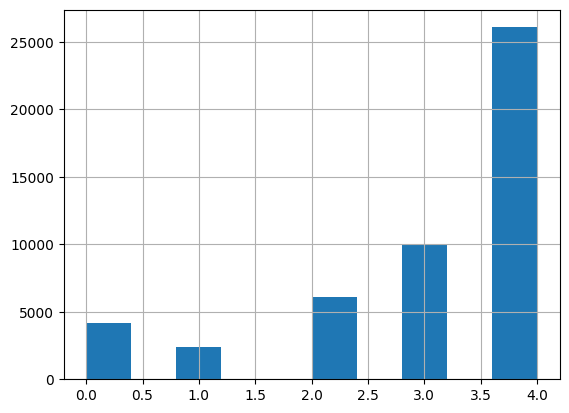

In [170]:
train_data['rate'].hist(); 

In [171]:
le = LabelEncoder()

train_data['rate'] = le.fit_transform(train_data['rate'])

# Оптимизация типов данных
train_data['rate'] = train_data['rate'].astype('uint8')

train_data.head()

,rate,text,clear_text
0,3,Очень понравилось. Были в начале марта с соба...,очень понравиться начало март собака дойти лес...
1,4,В целом магазин устраивает.\nАссортимент позво...,целое магазин устраивать ассортимент позволять...
2,4,"Очень хорошо что открылась 5 ка, теперь не над...",очень открыться ка далеко ехать рядом
3,2,Пятёрочка громко объявила о том как она заботи...,пята рочко громко объявить заботиться пенсионе...
4,2,"Тесно, вечная сутолока, между рядами трудно ра...",тесно вечный сутолока ряд трудно разойтись гря...


In [172]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48665 entries, 0 to 48664
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rate        48665 non-null  uint8 
 1   text        48665 non-null  object
 2   clear_text  48543 non-null  object
dtypes: object(2), uint8(1)
memory usage: 808.0+ KB


## Препроцессинг

In [173]:
import re
import string

import nltk
import pymorphy2

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Загрузка русских стоп-слов
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

# Инициализация анализатора pymorphy2
morph = pymorphy2.MorphAnalyzer()

# Инициализируем стеммер
stemmer = SnowballStemmer('russian')

def preprocess_text(text):
    # Удаление лишних символов и нормализация
    text = text.lower()
    
    # Удаление знаков пунктуации
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    
    # Дополнительно: удаление специальных символов или любых символов, кроме букв (латиница или кириллица)
    text = re.sub(r"[^a-zA-Zа-яА-Я\s]", " ", text)

    # Удаление множество пробелов
    text = text.replace(r'\s+','')
    
    
    # Токенизация
    tokens = word_tokenize(text, language="russian")
    
    # Удаление стоп-слов и лемматизация
    words_lemmatized = [morph.parse(word)[0].normal_form for word in tokens if word not in russian_stopwords]
    
    # Удаление стоп-слов и стемминг
    # words_stemmed = [stemmer.stem(word) for word in words if word not in russian_stopwords]
    
    return ' '.join(words_lemmatized)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [174]:
# train_data['clear_text'] = train_data['text'].apply(preprocess_text)

In [175]:
# test_data['clear_text'] = train_data['text'].apply(preprocess_text)

# DataSet

In [176]:
import torch
from torch.utils.data import Dataset


class FiveDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_seq_len):
        self.data = dataframe
        self.text = dataframe['text'].tolist()
        self.targets = None
        if 'rate' in dataframe:
            self.targets = dataframe['rate'].tolist()
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_seq_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if self.targets is not None:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'targets': torch.tensor(self.targets[index], dtype=torch.long)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
            }

    def __len__(self) -> int:
        return len(self.text)


# Модель


In [177]:
from typing import Dict

import torch
from transformers import AutoModel


class ModelForClassification(torch.nn.Module):

    def __init__(self, model_path: str, config: Dict):
        super(ModelForClassification, self).__init__()
        self.model_name = model_path
        self.config = config
        self.n_classes = config['num_classes']
        self.dropout_rate = config['dropout_rate']
        self.bert = AutoModel.from_pretrained(self.model_name)
        self.pre_classifier = torch.nn.Linear(312, 768)
        self.dropout = torch.nn.Dropout(self.dropout_rate)
        self.classifier = torch.nn.Linear(768, self.n_classes)

    def forward(self, input_ids, attention_mask,):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        hidden_state = output[0]
        hidden_state = hidden_state[:, 0]
        hidden_state = self.pre_classifier(hidden_state)
        hidden_state = torch.nn.ReLU()(hidden_state)
        hidden_state = self.dropout(hidden_state)
        output = self.classifier(hidden_state)
        return output



# Тренер

In [178]:
from typing import Dict

import torch
from numpy import asarray
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm.notebook import tqdm


class Trainer:
    def __init__(self, config: Dict):
        self.config = config
        self.n_epochs = config['n_epochs']
        self.optimizer = None
        self.opt_fn = lambda model: Adam(model.parameters(), config['lr'])
        self.model: ModelForClassification = None
        self.history = None
        self.loss_fn = CrossEntropyLoss()
        self.device = config['device']
        self.verbose = config.get('verbose', True)

    def fit(self, model, train_dataloader, val_dataloader):
        self.model = model.to(self.device)
        self.optimizer = self.opt_fn(model)
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }

        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}/{self.n_epochs}")
            train_info = self.train_epoch(train_dataloader)
            val_info = self.val_epoch(val_dataloader)
            self.history['train_loss'].extend(train_info['loss'])
            self.history['val_loss'].extend([val_info['loss']])
            self.history['val_acc'].extend([val_info['acc']])
        return self.model.eval()

    def train_epoch(self, train_dataloader):
        self.model.train()
        losses = []
        if self.verbose:
            train_dataloader = tqdm(train_dataloader)
        for batch in train_dataloader:
            ids = batch['ids'].to(self.device, dtype=torch.long)
            mask = batch['mask'].to(self.device, dtype=torch.long)
            targets = batch['targets'].to(self.device, dtype=torch.long)

            outputs = self.model(ids, mask)
            loss = self.loss_fn(outputs, targets)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_val = loss.item()
            if self.verbose:
                train_dataloader.set_description(f"Loss={loss_val:.3}")
            losses.append(loss_val)
        return {'loss': losses}

    def val_epoch(self, val_dataloader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_dataloader = tqdm(val_dataloader)
        with torch.no_grad():
            for batch in val_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                targets = batch['targets'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                all_logits.append(outputs)
                all_labels.append(targets)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits).to(self.device)
        loss = self.loss_fn(all_logits, all_labels).item()
        acc = (all_logits.argmax(1) == all_labels).float().mean().item()
        print(acc)
        if self.verbose:
            val_dataloader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
        return {
            'acc': acc,
            'loss': loss
        }

    def predict(self, test_dataloader):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                predictions.extend(outputs.argmax(1).tolist())
        return asarray(predictions)

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "config": self.model.config,
            "trainer_config": self.config,
            "model_name": self.model.model_name,
            "model_state_dict": self.model.state_dict()
        }
        torch.save(checkpoint, path)

    @classmethod
    def load(cls, path: str):
        ckpt = torch.load(path)
        keys = ["config", "trainer_config", "model_state_dict"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = ModelForClassification(
            ckpt['model_name'],
            ckpt["config"]
        )
        new_model.load_state_dict(ckpt["model_state_dict"])
        new_trainer = cls(ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer


# Выполнение

In [179]:
train_data_small = train_data[['text', 'rate']]

In [180]:
train_split, val_split = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['rate'])

In [181]:
tokenizer = AutoTokenizer.from_pretrained(
    "cointegrated/rubert-tiny2", truncation=True, do_lower_case=True)

In [182]:
train_dataset = FiveDataset(train_split, tokenizer, MAX_LEN)
val_dataset = FiveDataset(val_split, tokenizer, MAX_LEN)
test_dataset = FiveDataset(test_data, tokenizer, MAX_LEN)

In [183]:
train_params = {"batch_size": BATCH_SIZE,
                "shuffle": True,
                "num_workers": 0
                }

test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 0
               }

train_dataloader = DataLoader(train_dataset, **train_params)
val_dataloader = DataLoader(val_dataset, **test_params)
test_dataloader = DataLoader(test_dataset, **test_params)

In [184]:
config = {
    "num_classes": 5,
    "dropout_rate": 0.1
}
model = ModelForClassification(
    "cointegrated/rubert-tiny2",
    config=config
)

In [185]:
trainer_config = {
    "lr": 1e-3,
    "n_epochs": 5,
    "weight_decay": 1e-6,
    "batch_size": BATCH_SIZE,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}
t = Trainer(trainer_config)

In [186]:
t.fit(
    model,
    train_dataloader,
    val_dataloader
)

Epoch 1/5


  0%|          | 0/305 [00:00<?, ?it/s]

d:\Projects\NLP_course\.venv\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/77 [00:00<?, ?it/s]

0.6558101177215576
Epoch 2/5


  0%|          | 0/305 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

0.6499537825584412
Epoch 3/5


  0%|          | 0/305 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

0.6445083618164062
Epoch 4/5


  0%|          | 0/305 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

0.6207746863365173
Epoch 5/5


  0%|          | 0/305 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
t.save(DATA_PATH+"baseline_model.ckpt")
t = Trainer.load(DATA_PATH+"baseline_model.ckpt")

In [ ]:
predictions = t.predict(test_dataloader)

In [ ]:
sample_submission = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))
pred_labels = le.inverse_transform(predictions)
sample_submission["rate"] = predictions
sample_submission['rate'] = le.inverse_transform(sample_submission['rate'])

# sample_submission.loc[sample_submission['rate'] == 5, 'rate'] = 4
sample_submission['rate'] = sample_submission['rate'].apply(lambda a: a + 1)

sample_submission['rate'].unique()


array([5, 4, 1, 3, 2], dtype=int64)

In [ ]:
sample_submission.head()

,index,rate
0,0,5
1,1,4
2,2,5
3,3,4
4,4,1


In [ ]:
sample_submission.to_csv(DATA_PATH+"submission.csv", index=False)